In [9]:

from sklearn.metrics import rand_score, silhouette_score, confusion_matrix, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import gower
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import squareform
from scipy.optimize import linear_sum_assignment
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import pairwise_distances
import json
import seaborn as sns

In [2]:
file_path = 'data_preprocessed.csv'
data = pd.read_csv(file_path)
data = data.dropna()


# Identify numerical and categorical columns
numerical_columns = ['age','fnlwgt', 'hours-per-week', 'capital-gain', 'capital-loss']  # Replace with your actual numerical columns
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']  # Replace with your actual categorical columns
sorted_columns = ['age','fnlwgt', 'hours-per-week', 'capital-gain', 'capital-loss', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

y = pd.get_dummies(data['income'], drop_first=True)
y = y.values.reshape(-1)
X = data.drop('income', axis=1)

for col in categorical_columns:
    X[col] = X[col].astype('category')

X = X[sorted_columns]

X, _, y, _ = train_test_split(X, y, train_size=5000, stratify=y, random_state=42)

In [3]:
gower_dist = gower.gower_matrix(X, cat_features = [False]*len(numerical_columns)+[True]*len(categorical_columns))

In [4]:
# range for the number of clusters
range_n_clusters = list(range(2, 11))

In [5]:
# dictionary to store results
results = {
    'PAM': [],
    'AGNES_single': [],
    'AGNES_complete': [],
    'AGNES_average': [],
    'AGNES_ward': [],
    'KPrototypes': []
}

In [6]:
# PAM (KMedoids)
for n_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed', method='pam', init='random')
    cluster_labels = kmedoids.fit_predict(gower_dist)
    
    silhouette_avg = silhouette_score(gower_dist, cluster_labels, metric="precomputed")
    db_score = davies_bouldin_score(gower_dist, cluster_labels)
    ch_score = calinski_harabasz_score(gower_dist, cluster_labels)
    inertia = kmedoids.inertia_
    
    results['PAM'].append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg,
        'davies_bouldin_score': db_score,
        'calinski_harabasz_score': ch_score,
        'inertia': inertia
    })

In [7]:
# AGNES (All Linkage Methods)
gower_condensed = squareform(gower_dist, checks=False)

linkage_methods = ['single', 'complete', 'average', 'ward']
for method in linkage_methods:
    agnes = linkage(gower_condensed, method=method)
    for n_clusters in range_n_clusters:
        cluster_labels = fcluster(agnes, n_clusters, criterion='maxclust')
        
        silhouette_avg = silhouette_score(gower_dist, cluster_labels, metric="precomputed")
        db_score = davies_bouldin_score(gower_dist, cluster_labels)
        ch_score = calinski_harabasz_score(gower_dist, cluster_labels)
        
        results[f'AGNES_{method}'].append({
            'n_clusters': n_clusters,
            'silhouette_score': silhouette_avg,
            'davies_bouldin_score': db_score,
            'calinski_harabasz_score': ch_score
        })

In [5]:
X_categorical = X.copy()
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X_categorical[col] = le.fit_transform(X_categorical[col])
    label_encoders[col] = le

In [8]:
# KPrototypes
categorical_indices = [X_categorical.columns.get_loc(col) for col in categorical_columns]
for n_clusters in range_n_clusters:
    kprototypes = KPrototypes(n_clusters=n_clusters, random_state=42)
    cluster_labels = kprototypes.fit_predict(X_categorical, categorical=categorical_indices)
    
    db_score = davies_bouldin_score(X_categorical, cluster_labels)
    ch_score = calinski_harabasz_score(X_categorical, cluster_labels)
    cost = kprototypes.cost_
    
    results['KPrototypes'].append({
        'n_clusters': n_clusters,
        'davies_bouldin_score': db_score,
        'calinski_harabasz_score': ch_score,
        'cost': cost
    })

In [9]:
def convert_to_serializable(obj):
    """
    Recursively convert numpy.float32 to Python float in a dictionary.
    """
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    elif isinstance(obj, np.float32):
        return float(obj)
    return obj

In [10]:
results = convert_to_serializable(results)

In [11]:
for method, method_results in results.items():
    with open(f'clustering_results/{method}_results.json', 'w') as file:
        json.dump(method_results, file, indent=4)

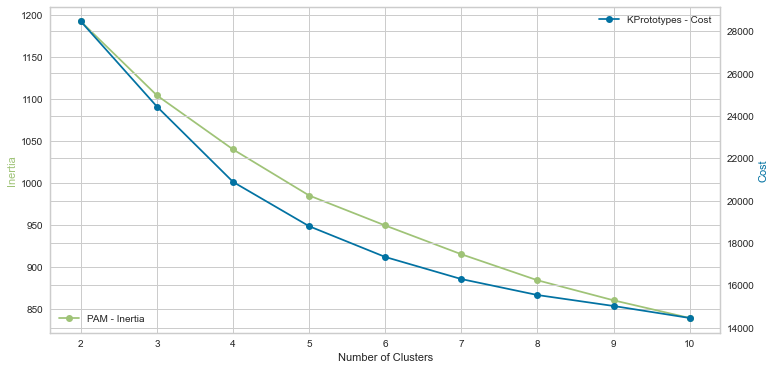

In [18]:
import json
import matplotlib.pyplot as plt

# Function to load results from a JSON file
def load_results(filename):
    with open(filename, 'r') as file:
        return json.load(file)

# Load the results for KPrototypes and PAM
kprototypes_results = load_results('clustering_results/KPrototypes_results.json')
pam_results = load_results('clustering_results/PAM_results.json')

# Extract the number of clusters and inertia values for KPrototypes
n_clusters_kprototypes = [result['n_clusters'] for result in kprototypes_results]
cost_values_kprototypes = [result['cost'] for result in kprototypes_results]

# Extract the number of clusters and inertia values for PAM
n_clusters_pam = [result['n_clusters'] for result in pam_results]
inertia_values_pam = [result['inertia'] for result in pam_results]

# Plot the inertia vs. number of clusters for KPrototypes
# plt.figure(figsize=(10, 6))
# plt.plot(n_clusters_pam, inertia_values_pam, marker='o', linestyle='-', color='r', label='PAM')
# plt.title('Inertia vs Number of Clusters for KPrototypes and PAM')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')
# plt.legend()
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(n_clusters_kprototypes, cost_values_kprototypes, marker='o', linestyle='-', color='b', label='KPrototypes')
# plt.title('Inertia and Cost vs Number of Clusters for PAM and KPrototypes')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Cost')
# plt.legend()
# plt.grid(True)
# plt.show()
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting Inertia for PAM
ax1.plot(n_clusters_pam, inertia_values_pam, marker='o', linestyle='-', color='C1', label='PAM - Inertia')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color='C1')
ax1.tick_params(axis='y')
ax1.legend(loc='lower left')
ax1.grid(True)

# Creating a second y-axis for the Cost of KPrototypes
ax2 = ax1.twinx()
ax2.plot(n_clusters_kprototypes, cost_values_kprototypes, marker='o', linestyle='-', color='C0', label='KPrototypes - Cost')
ax2.set_ylabel('Cost', color='C0')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

# plt.title('Inertia and Cost vs Number of Clusters for PAM and KPrototypes')
plt.savefig('clustering_plots/cost_inertia.pdf')
plt.show()

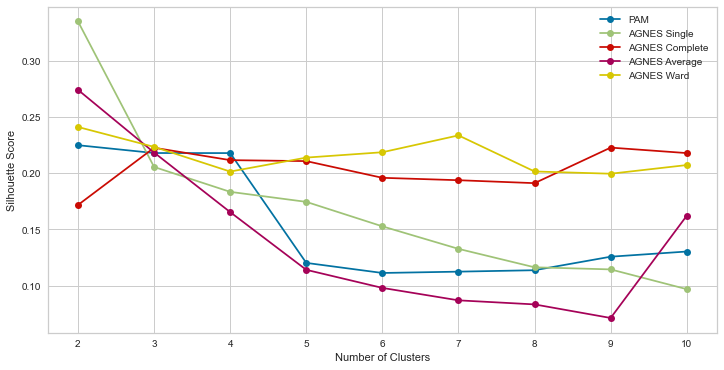

In [19]:
kprototypes_results = load_results('clustering_results/KPrototypes_results.json')
pam_results = load_results('clustering_results/PAM_results.json')
agnes_single_results = load_results('clustering_results/AGNES_single_results.json')
agnes_complete_results = load_results('clustering_results/AGNES_complete_results.json')
agnes_average_results = load_results('clustering_results/AGNES_average_results.json')
agnes_ward_results = load_results('clustering_results/AGNES_ward_results.json')

# Extract the number of clusters and silhouette scores for each algorithm
def extract_metric(results, metric):
    n_clusters = [result['n_clusters'] for result in results]
    metric_values = [result[metric] for result in results]
    return n_clusters, metric_values

n_clusters_pam, silhouette_pam = extract_metric(pam_results, 'silhouette_score')
n_clusters_agnes_single, silhouette_agnes_single = extract_metric(agnes_single_results, 'silhouette_score')
n_clusters_agnes_complete, silhouette_agnes_complete = extract_metric(agnes_complete_results, 'silhouette_score')
n_clusters_agnes_average, silhouette_agnes_average = extract_metric(agnes_average_results, 'silhouette_score')
n_clusters_agnes_ward, silhouette_agnes_ward = extract_metric(agnes_ward_results, 'silhouette_score')

# Plot the silhouette scores vs. number of clusters for each algorithm
plt.figure(figsize=(12, 6))

# plt.plot(n_clusters_kprototypes, silhouette_kprototypes, marker='o', linestyle='-', label='KPrototypes')
plt.plot(n_clusters_pam, silhouette_pam, marker='o', linestyle='-', label='PAM')
plt.plot(n_clusters_agnes_single, silhouette_agnes_single, marker='o', linestyle='-', label='AGNES Single')
plt.plot(n_clusters_agnes_complete, silhouette_agnes_complete, marker='o', linestyle='-', label='AGNES Complete')
plt.plot(n_clusters_agnes_average, silhouette_agnes_average, marker='o', linestyle='-', label='AGNES Average')
plt.plot(n_clusters_agnes_ward, silhouette_agnes_ward, marker='o', linestyle='-', label='AGNES Ward')

# plt.title('Silhouette Score vs Number of Clusters for Different Algorithms')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.savefig('clustering_plots/silhoutte_all.pdf')
plt.show()

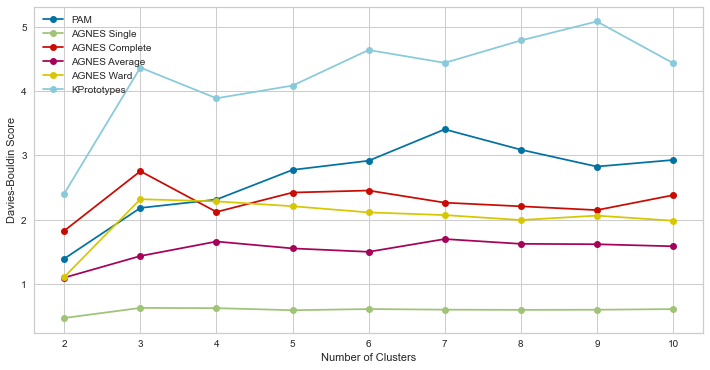

In [20]:
n_clusters_kprototypes, db_kprototypes = extract_metric(kprototypes_results, 'davies_bouldin_score')
n_clusters_pam, db_pam = extract_metric(pam_results, 'davies_bouldin_score')
n_clusters_agnes_single, db_agnes_single = extract_metric(agnes_single_results, 'davies_bouldin_score')
n_clusters_agnes_complete, db_agnes_complete = extract_metric(agnes_complete_results, 'davies_bouldin_score')
n_clusters_agnes_average, db_agnes_average = extract_metric(agnes_average_results, 'davies_bouldin_score')
n_clusters_agnes_ward, db_agnes_ward = extract_metric(agnes_ward_results, 'davies_bouldin_score')

# Plot the Davies-Bouldin scores vs. number of clusters for each algorithm
plt.figure(figsize=(12, 6))


plt.plot(n_clusters_pam, db_pam, marker='o', linestyle='-', label='PAM')
plt.plot(n_clusters_agnes_single, db_agnes_single, marker='o', linestyle='-', label='AGNES Single')
plt.plot(n_clusters_agnes_complete, db_agnes_complete, marker='o', linestyle='-', label='AGNES Complete')
plt.plot(n_clusters_agnes_average, db_agnes_average, marker='o', linestyle='-', label='AGNES Average')
plt.plot(n_clusters_agnes_ward, db_agnes_ward, marker='o', linestyle='-', label='AGNES Ward')
plt.plot(n_clusters_kprototypes, db_kprototypes, marker='o', linestyle='-', label='KPrototypes')
# plt.title('Davies-Bouldin Score vs Number of Clusters for Different Algorithms')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.legend()
plt.grid(True)
plt.savefig('clustering_plots/davies.pdf')
plt.show()

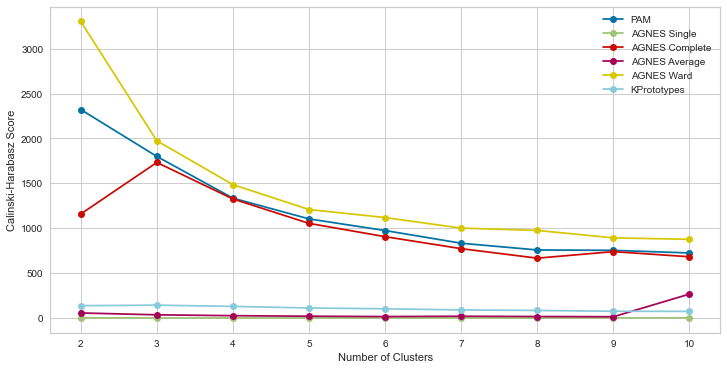

In [21]:
n_clusters_kprototypes, ch_kprototypes = extract_metric(kprototypes_results, 'calinski_harabasz_score')
n_clusters_pam, ch_pam = extract_metric(pam_results, 'calinski_harabasz_score')
n_clusters_agnes_single, ch_agnes_single = extract_metric(agnes_single_results, 'calinski_harabasz_score')
n_clusters_agnes_complete, ch_agnes_complete = extract_metric(agnes_complete_results, 'calinski_harabasz_score')
n_clusters_agnes_average, ch_agnes_average = extract_metric(agnes_average_results, 'calinski_harabasz_score')
n_clusters_agnes_ward, ch_agnes_ward = extract_metric(agnes_ward_results, 'calinski_harabasz_score')

# Plot the Calinski-Harabasz scores vs. number of clusters for each algorithm
plt.figure(figsize=(12, 6))


plt.plot(n_clusters_pam, ch_pam, marker='o', linestyle='-', label='PAM')
plt.plot(n_clusters_agnes_single, ch_agnes_single, marker='o', linestyle='-', label='AGNES Single')
plt.plot(n_clusters_agnes_complete, ch_agnes_complete, marker='o', linestyle='-', label='AGNES Complete')
plt.plot(n_clusters_agnes_average, ch_agnes_average, marker='o', linestyle='-', label='AGNES Average')
plt.plot(n_clusters_agnes_ward, ch_agnes_ward, marker='o', linestyle='-', label='AGNES Ward')
plt.plot(n_clusters_kprototypes, ch_kprototypes, marker='o', linestyle='-', label='KPrototypes')
# plt.title('Calinski-Harabasz Score vs Number of Clusters for Different Algorithms')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Score')
plt.legend()
plt.grid(True)
plt.savefig('clustering_plots/calinski.pdf')
plt.show()

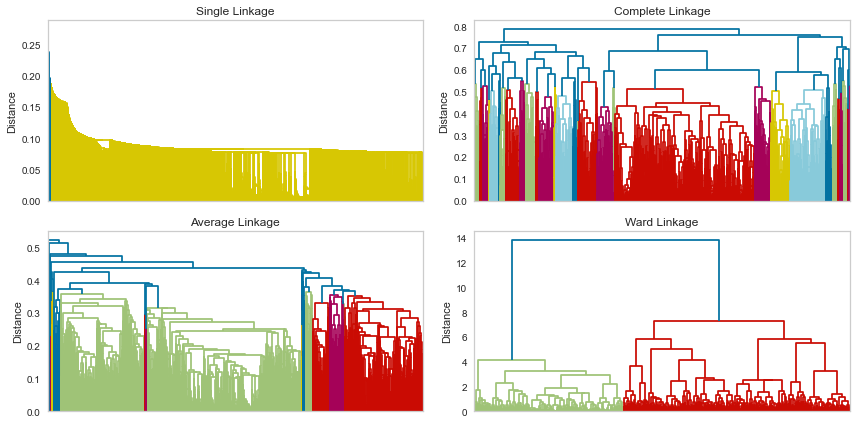

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()

for ax, method in zip(axes, linkage_methods):
    # Perform hierarchical clustering using the linkage function
    agnes = linkage(gower_condensed, method=method)
    
    # Plot the dendrogram
    dendrogram(agnes, ax=ax)
    ax.set_title(f'{method.capitalize()} Linkage')
    ax.set_ylabel('Distance')
    ax.grid(False)
    ax.set_xticks([])

plt.tight_layout()
plt.savefig('clustering_plots/dendrogram.pdf')
plt.savefig('clustering_plots/dendrogram.png')
plt.show()

# PAM  (KMEDIOIDS)

https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html

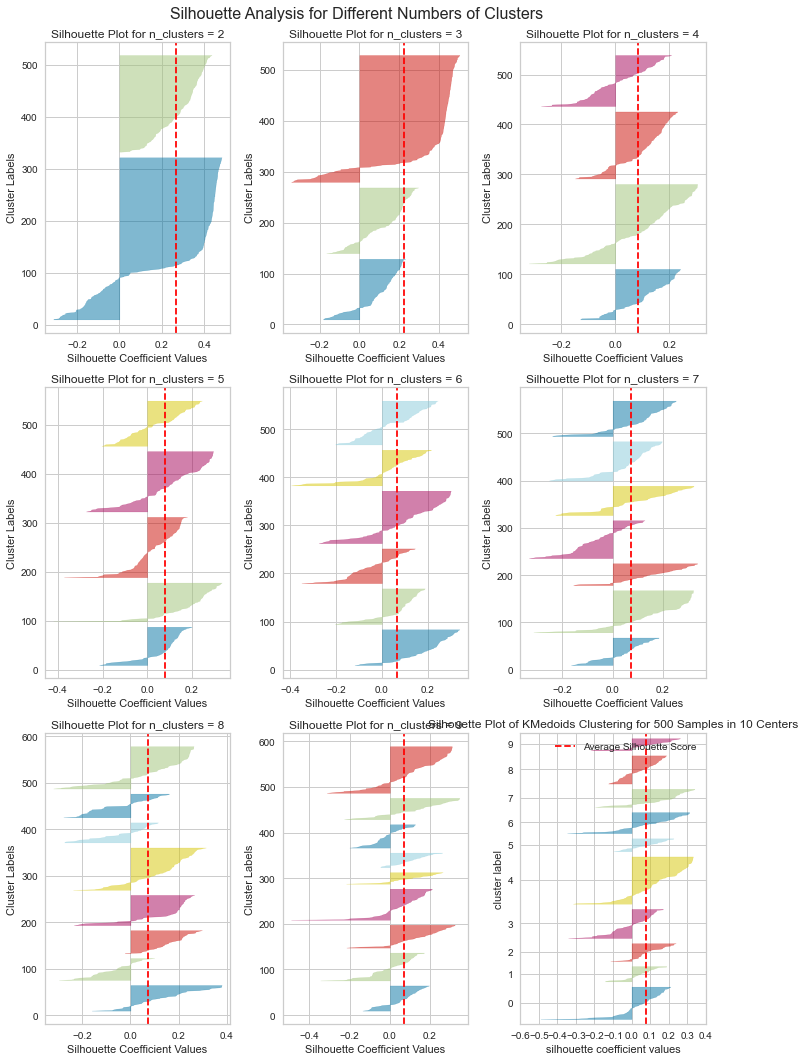

<Axes: title={'center': 'Silhouette Plot of KMedoids Clustering for 500 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [37]:
# Define a range for the number of clusters
range_n_clusters = list(range(2, 11))


fig, ax = plt.subplots(3, 3, figsize=(10,15))
# Perform KMedoids clustering and calculate silhouette scores for each number of clusters
for n_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed', method='pam', init='random')
    q, mod = divmod(n_clusters+1, 3)

    visualizer_sil = SilhouetteVisualizer(kmedoids, colors='yellowbrick', ax=ax[q-1][mod], metric='precomputed')
    visualizer_sil.fit(gower_dist)
    visualizer_sil.set_title(f'Silhouette Plot for n_clusters = {n_clusters}')
    visualizer_sil.ax.set_xlabel('Silhouette Coefficient Values')
    visualizer_sil.ax.set_ylabel('Cluster Labels')
    


plt.tight_layout(rect=[0, 0, 1, 0.97])
fig.suptitle('Silhouette Analysis for Different Numbers of Clusters', fontsize=16)
# visualizer_sil.show()

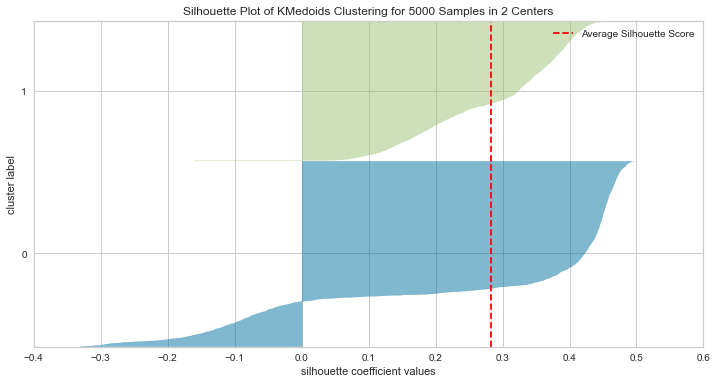

In [17]:
kmedoids = KMedoids(n_clusters=2, metric='precomputed', method='pam', init='random')

plt.figure(figsize=(12, 6))
# Create the SilhouetteVisualizer
visualizer_sil = SilhouetteVisualizer(kmedoids, colors='yellowbrick', metric='precomputed')
visualizer_sil.fit(gower_dist)

# Show the plot
visualizer_sil.show(outpath='clustering_plots/silhouette_plot.pdf')
plt.show()

In [6]:
linkage_methods = ['single', 'complete', 'average', 'ward']
models = {'True Labels': y}

In [7]:
# KMedoids
kmedoids = KMedoids(n_clusters=2, metric='precomputed', method='pam', init='random')
models['PAM'] = kmedoids.fit_predict(gower_dist)

# AGNES for each linkage method
gower_condensed = squareform(gower_dist, checks=False)
for method in linkage_methods:
    agnes = linkage(gower_condensed, method=method)
    cluster_labels = fcluster(agnes, 2, criterion='maxclust')
    models[f'AGNES_{method}'] = cluster_labels

# KPrototypes
categorical_indices = [X_categorical.columns.get_loc(col) for col in categorical_columns]
kprototypes = KPrototypes(n_clusters=2, random_state=42)
models['KPrototypes'] = kprototypes.fit_predict(X_categorical, categorical=categorical_indices)

# Calculate Rand Index between every pair of models
model_names = list(models.keys())
n_models = len(model_names)
rand_index_matrix = np.zeros((n_models, n_models))

for i in range(n_models):
    for j in range(n_models):
        if i != j:
            rand_index_matrix[i, j] = rand_score(models[model_names[i]], models[model_names[j]])
        else:
            rand_index_matrix[i, j] = 1.0  # Rand index with itself


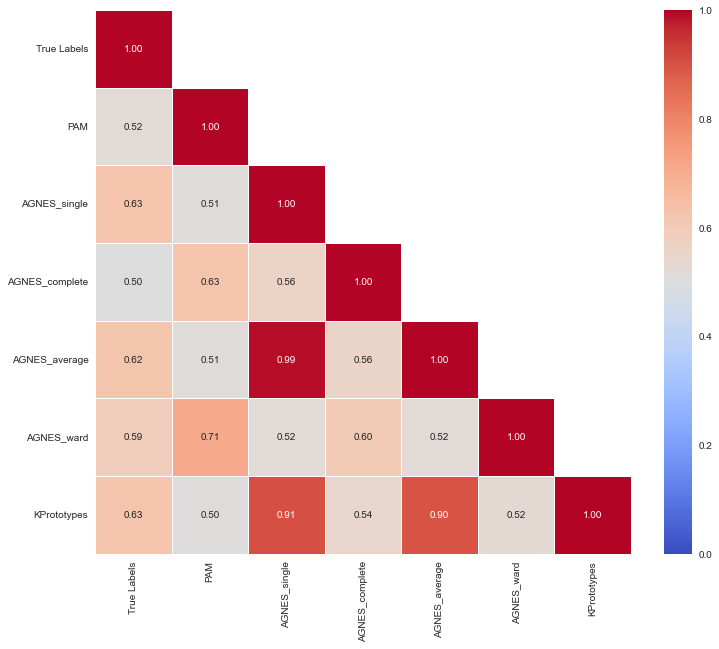

In [26]:
# Convert to DataFrame for better visualization
rand_index_df = pd.DataFrame(rand_index_matrix, index=model_names, columns=model_names)

# Plot the Rand Index matrix
plt.figure(figsize=(12, 10))
sns.heatmap(rand_index_df, annot=True, cmap='coolwarm', vmin=0, vmax=1,fmt=".2f", linewidth=1,mask=np.triu(rand_index_df, k=1), linecolor='white')
# plt.title('Rand Index Between Different Clustering Models for k=2')
plt.grid(False)
plt.savefig('clustering_plots/rand.pdf')
plt.show()



In [17]:
X_with_labels = X.copy()

In [19]:
kmedoids = KMedoids(n_clusters=2, metric='precomputed', method='pam', init='random')
cluster_labels = kmedoids.fit_predict(gower_dist)

# Add cluster labels to the DataFrame
X_with_labels['cluster_pam'] = cluster_labels

In [51]:
X_with_labels[numerical_columns] = scaler.inverse_transform(X_with_labels[numerical_columns])

<ipython-input-54-9333c7beac7d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_pam', y=feature, data=X_with_labels, ax=axes[row, col],showfliers=True,
<ipython-input-54-9333c7beac7d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_pam', y=feature, data=X_with_labels, ax=axes[row, col],showfliers=True,
<ipython-input-54-9333c7beac7d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_pam', y=feature, data=X_with_labels, ax=axes[row, col],showfliers=True,
<ipython-input-54-9333c7beac7d>:8: FutureWarning: 

Pas

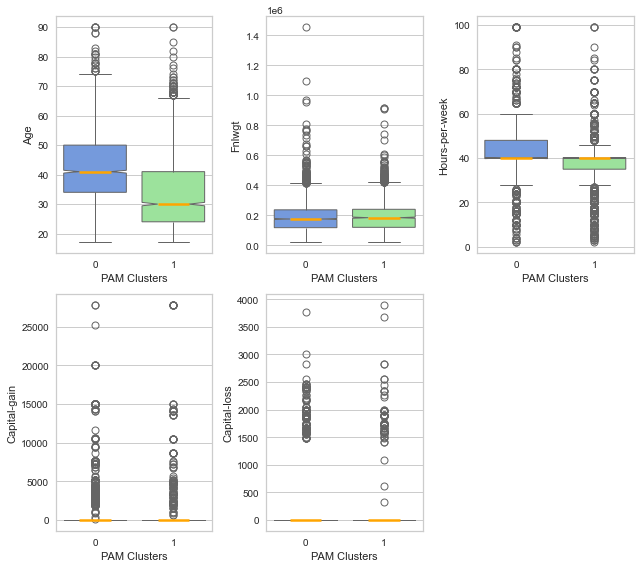

In [54]:
# Create subplots for each numerical feature
n_features = len(numerical_columns)
fig, axes = plt.subplots(2, 3, figsize=(9, 8))

for i, feature in enumerate(numerical_columns):
    row = i // 3
    col = i % 3
    sns.boxplot(x='cluster_pam', y=feature, data=X_with_labels, ax=axes[row, col],showfliers=True,
                palette={"0": "cornflowerblue", "1": "lightgreen"}, notch=True,
                flierprops={"marker": 'o'}, medianprops=dict(linestyle='-', linewidth=2.5, color='orange'))
    axes[row, col].set_xlabel('PAM Clusters')
    axes[row, col].set_ylabel(feature.capitalize())
# Turn off the last subplot if it's not used
if len(numerical_columns) < 6:
    fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.savefig('clustering_plots/pam_variables.pdf')
plt.show()

In [55]:
agnes = linkage(gower_condensed, method='average')
cluster_labels = fcluster(agnes, 2, criterion='maxclust')

# Add cluster labels to the DataFrame
X_with_labels['cluster_agnes'] = cluster_labels

<ipython-input-58-f148e05d2cb0>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_agnes', y=feature, data=X_with_labels, ax=axes[row, col],showfliers=True,
<ipython-input-58-f148e05d2cb0>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_agnes', y=feature, data=X_with_labels, ax=axes[row, col],showfliers=True,
<ipython-input-58-f148e05d2cb0>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_agnes', y=feature, data=X_with_labels, ax=axes[row, col],showfliers=True,
<ipython-input-58-f148e05d2cb0>:8: FutureWarning:

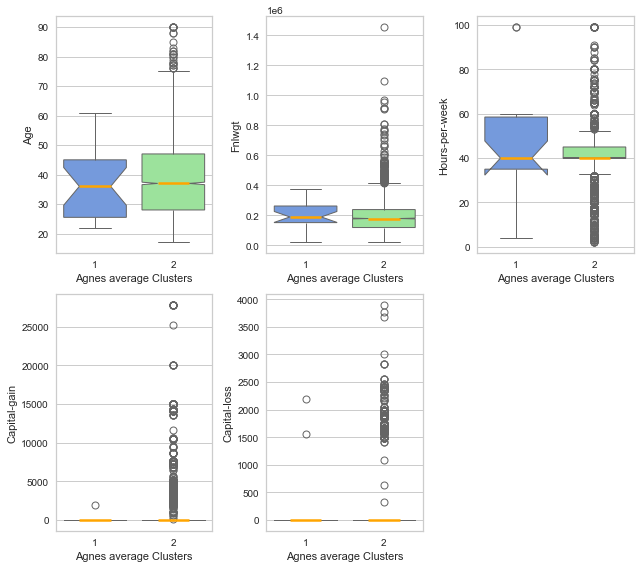

In [58]:
# Create subplots for each numerical feature
n_features = len(numerical_columns)
fig, axes = plt.subplots(2, 3, figsize=(9, 8))

for i, feature in enumerate(numerical_columns):
    row = i // 3
    col = i % 3
    sns.boxplot(x='cluster_agnes', y=feature, data=X_with_labels, ax=axes[row, col],showfliers=True,
                palette={"1": "cornflowerblue", "2": "lightgreen"}, notch=True,
                flierprops={"marker": 'o'}, medianprops=dict(linestyle='-', linewidth=2.5, color='orange'))
    axes[row, col].set_xlabel('Agnes average Clusters')
    axes[row, col].set_ylabel(feature.capitalize())
# Turn off the last subplot if it's not used
if len(numerical_columns) < 6:
    fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.savefig('clustering_plots/agnes_variables.pdf')
plt.show()

In [59]:
categorical_indices = [X_categorical.columns.get_loc(col) for col in categorical_columns]
kprototypes = KPrototypes(n_clusters=2, random_state=42)
cluster_labels = kprototypes.fit_predict(X_categorical, categorical=categorical_indices)


# Add cluster labels to the DataFrame
X_with_labels['cluster_kprototypes'] = cluster_labels

<ipython-input-61-bf07d26515b1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_kprototypes', y=feature, data=X_with_labels, ax=axes[row, col],showfliers=True,
<ipython-input-61-bf07d26515b1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_kprototypes', y=feature, data=X_with_labels, ax=axes[row, col],showfliers=True,
<ipython-input-61-bf07d26515b1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster_kprototypes', y=feature, data=X_with_labels, ax=axes[row, col],showfliers=True,
<ipython-input-61-bf07d26515b1>

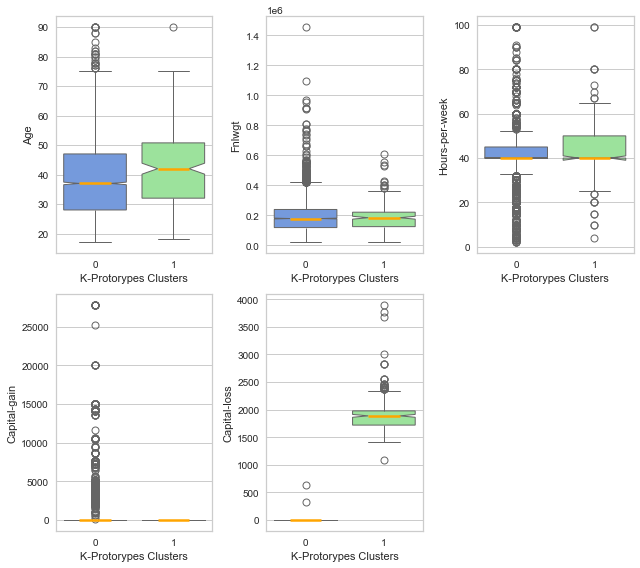

In [61]:
# Create subplots for each numerical feature
n_features = len(numerical_columns)
fig, axes = plt.subplots(2, 3, figsize=(9, 8))

for i, feature in enumerate(numerical_columns):
    row = i // 3
    col = i % 3
    sns.boxplot(x='cluster_kprototypes', y=feature, data=X_with_labels, ax=axes[row, col],showfliers=True,
                palette={"0": "cornflowerblue", "1": "lightgreen"}, notch=True,
                flierprops={"marker": 'o'}, medianprops=dict(linestyle='-', linewidth=2.5, color='orange'))
    axes[row, col].set_xlabel('K-Protorypes Clusters')
    axes[row, col].set_ylabel(feature.capitalize())
# Turn off the last subplot if it's not used
if len(numerical_columns) < 6:
    fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.savefig('clustering_plots/kprototypes_variables.pdf')
plt.show()

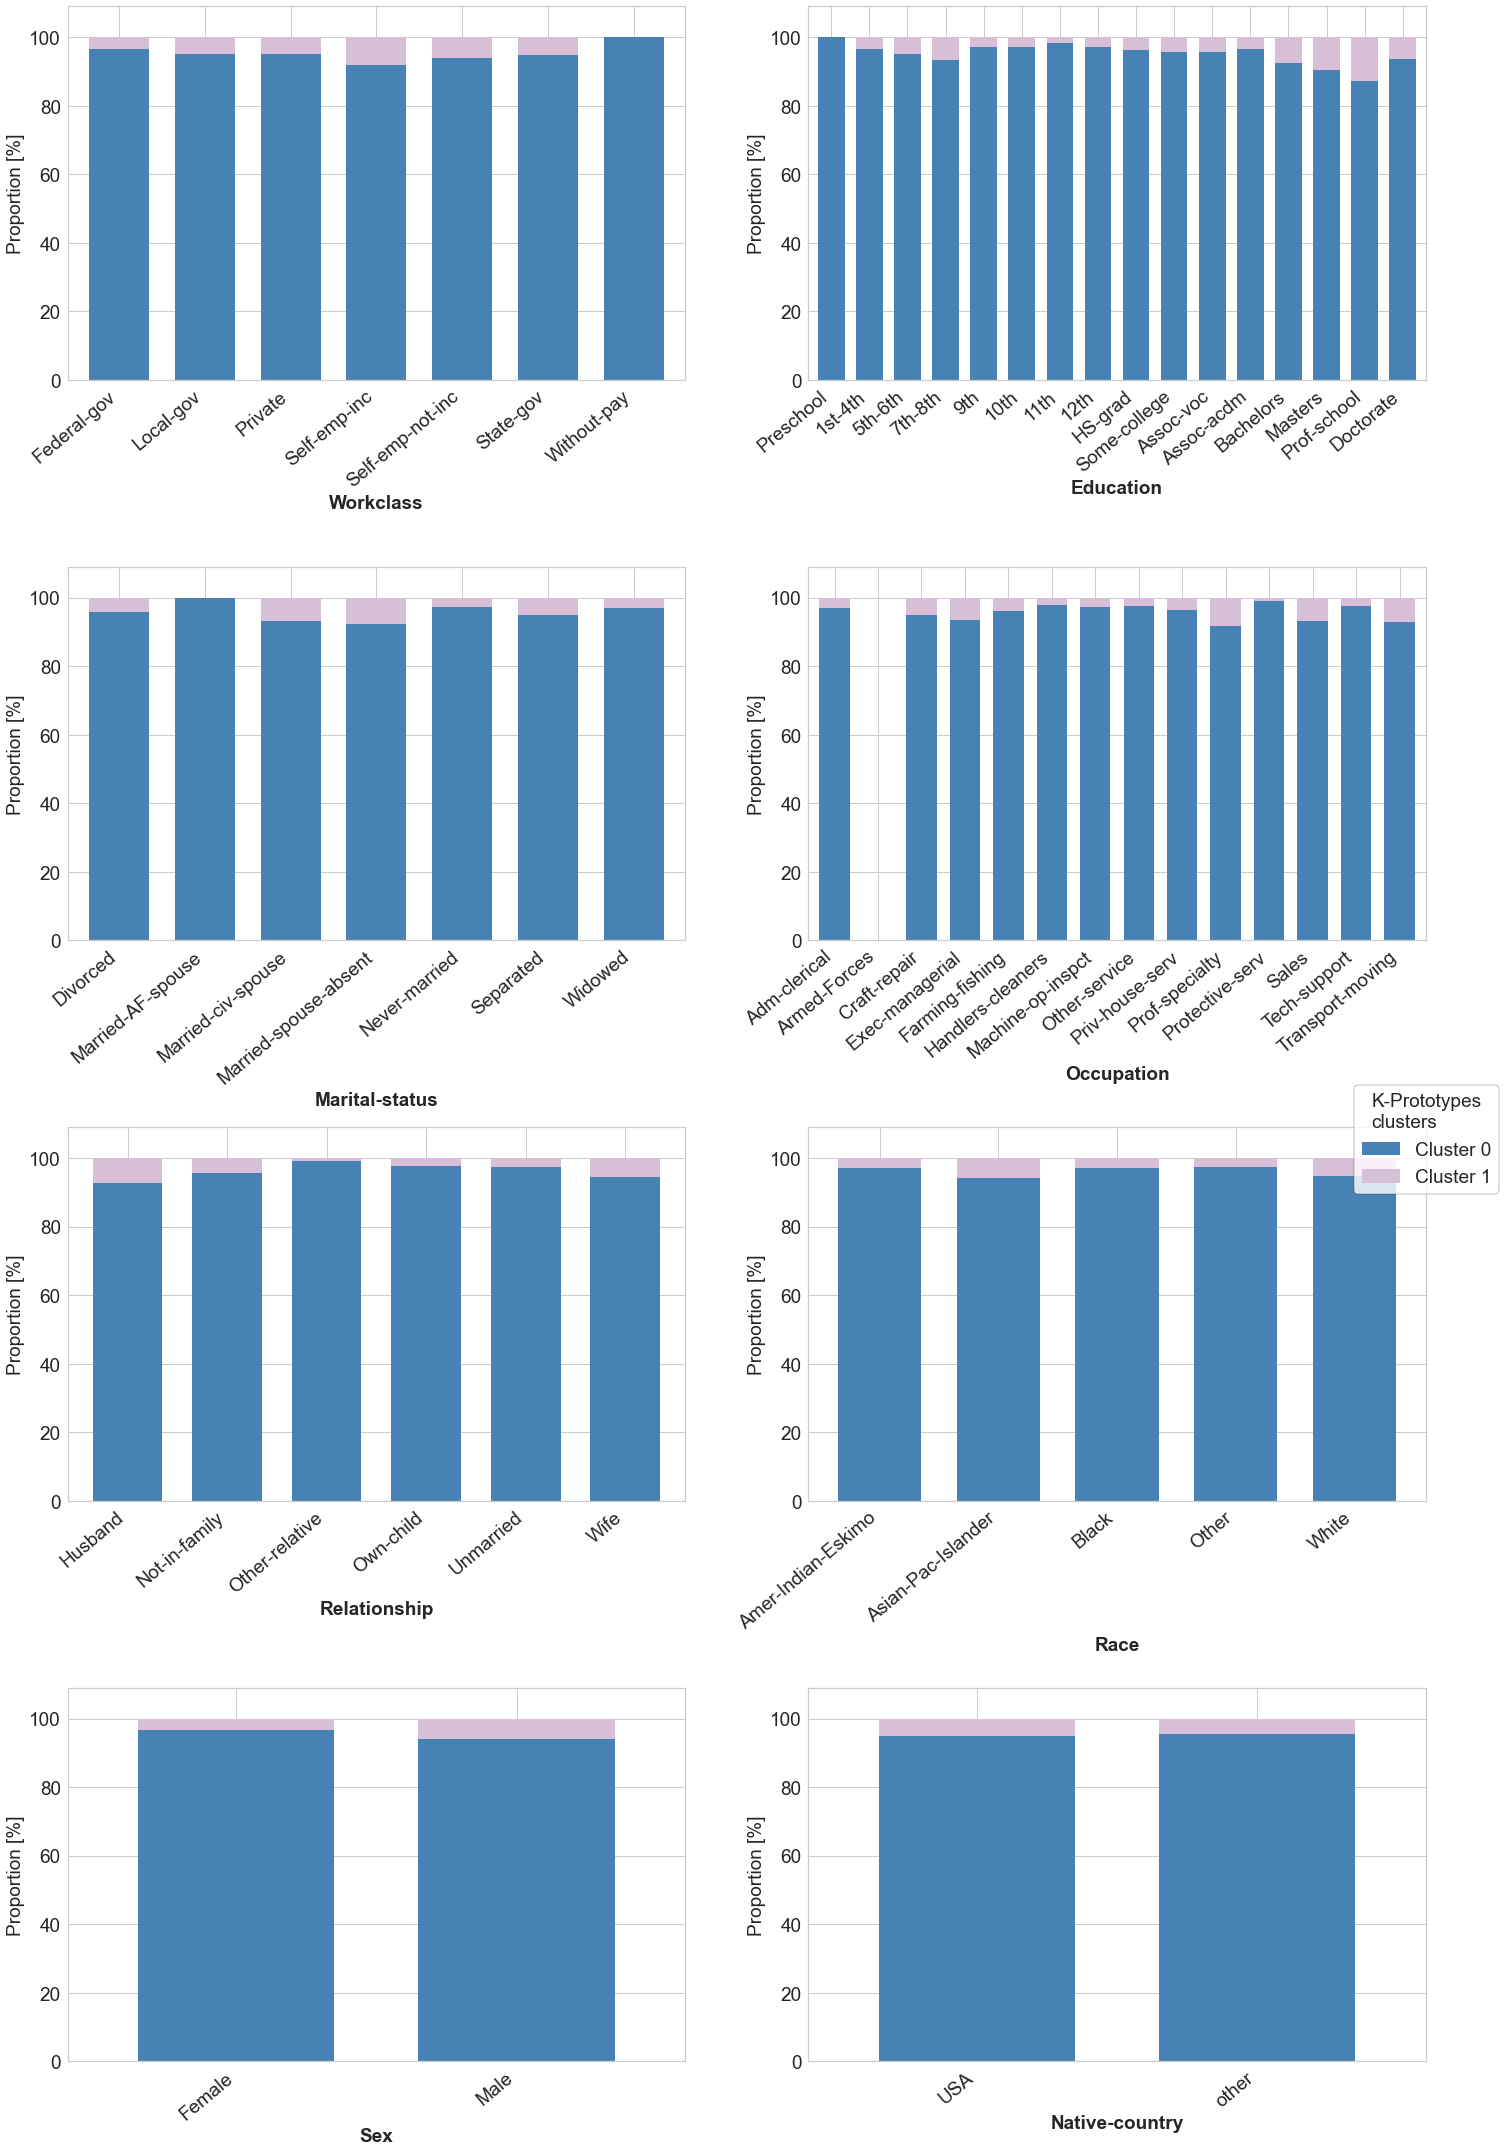

In [79]:
education_sorted = [
    'Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th',
    'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters',
    'Prof-school', 'Doctorate'
]

colors = ['steelblue', 'thistle']
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 30))

for i, feature in enumerate(categorical_columns):
    ax = axes[i // 2, i % 2]
    
    if feature == 'education':
        grouped = X_with_labels.groupby([pd.Categorical(X_with_labels['education'], categories=education_sorted, ordered=True), 'cluster_kprototypes']).size().unstack()
    else:
        grouped = X_with_labels.groupby([feature, 'cluster_kprototypes']).size().unstack()
        
    grouped_percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100
    grouped_percentages.plot(kind='bar', stacked=True, color=colors, width=0.7, fontsize=15, ax=ax)
    
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=19, rotation=40, ha='right')
    ax.set_yticks(ax.get_yticks())
    ax.set_xlabel(f"{feature.capitalize()}", fontsize=19, weight='bold')
    ax.set_ylabel("Proportion [%]", fontsize=19)
    # ax.legend(title='K-Prototypes clusters', loc='upper right', fontsize=19, title_fontsize=19, fancybox=True)
    # legend = ax.legend(title='Cluster', loc='upper right', fontsize=19, title_fontsize=19)
    # legend.get_frame().set_edgecolor('black')
#     legend.get_frame().set_linewidth(1)
    ax.legend().remove()
    ax.set_ylim(0, 109)
    ax.tick_params(axis='y', labelsize=19)
# plt.legend(title='K-Prototypes clusters', loc='upper right',fontsize=19)
fig.legend(title='K-Prototypes\nclusters', labels=['Cluster 0', 'Cluster 1'], loc='upper right', fontsize=19, title_fontsize=19, bbox_to_anchor=(1.05, 0.5), edgecolor='black', frameon=True)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.savefig('clustering_plots/kprototypes_variables_categorical.pdf')
plt.show()

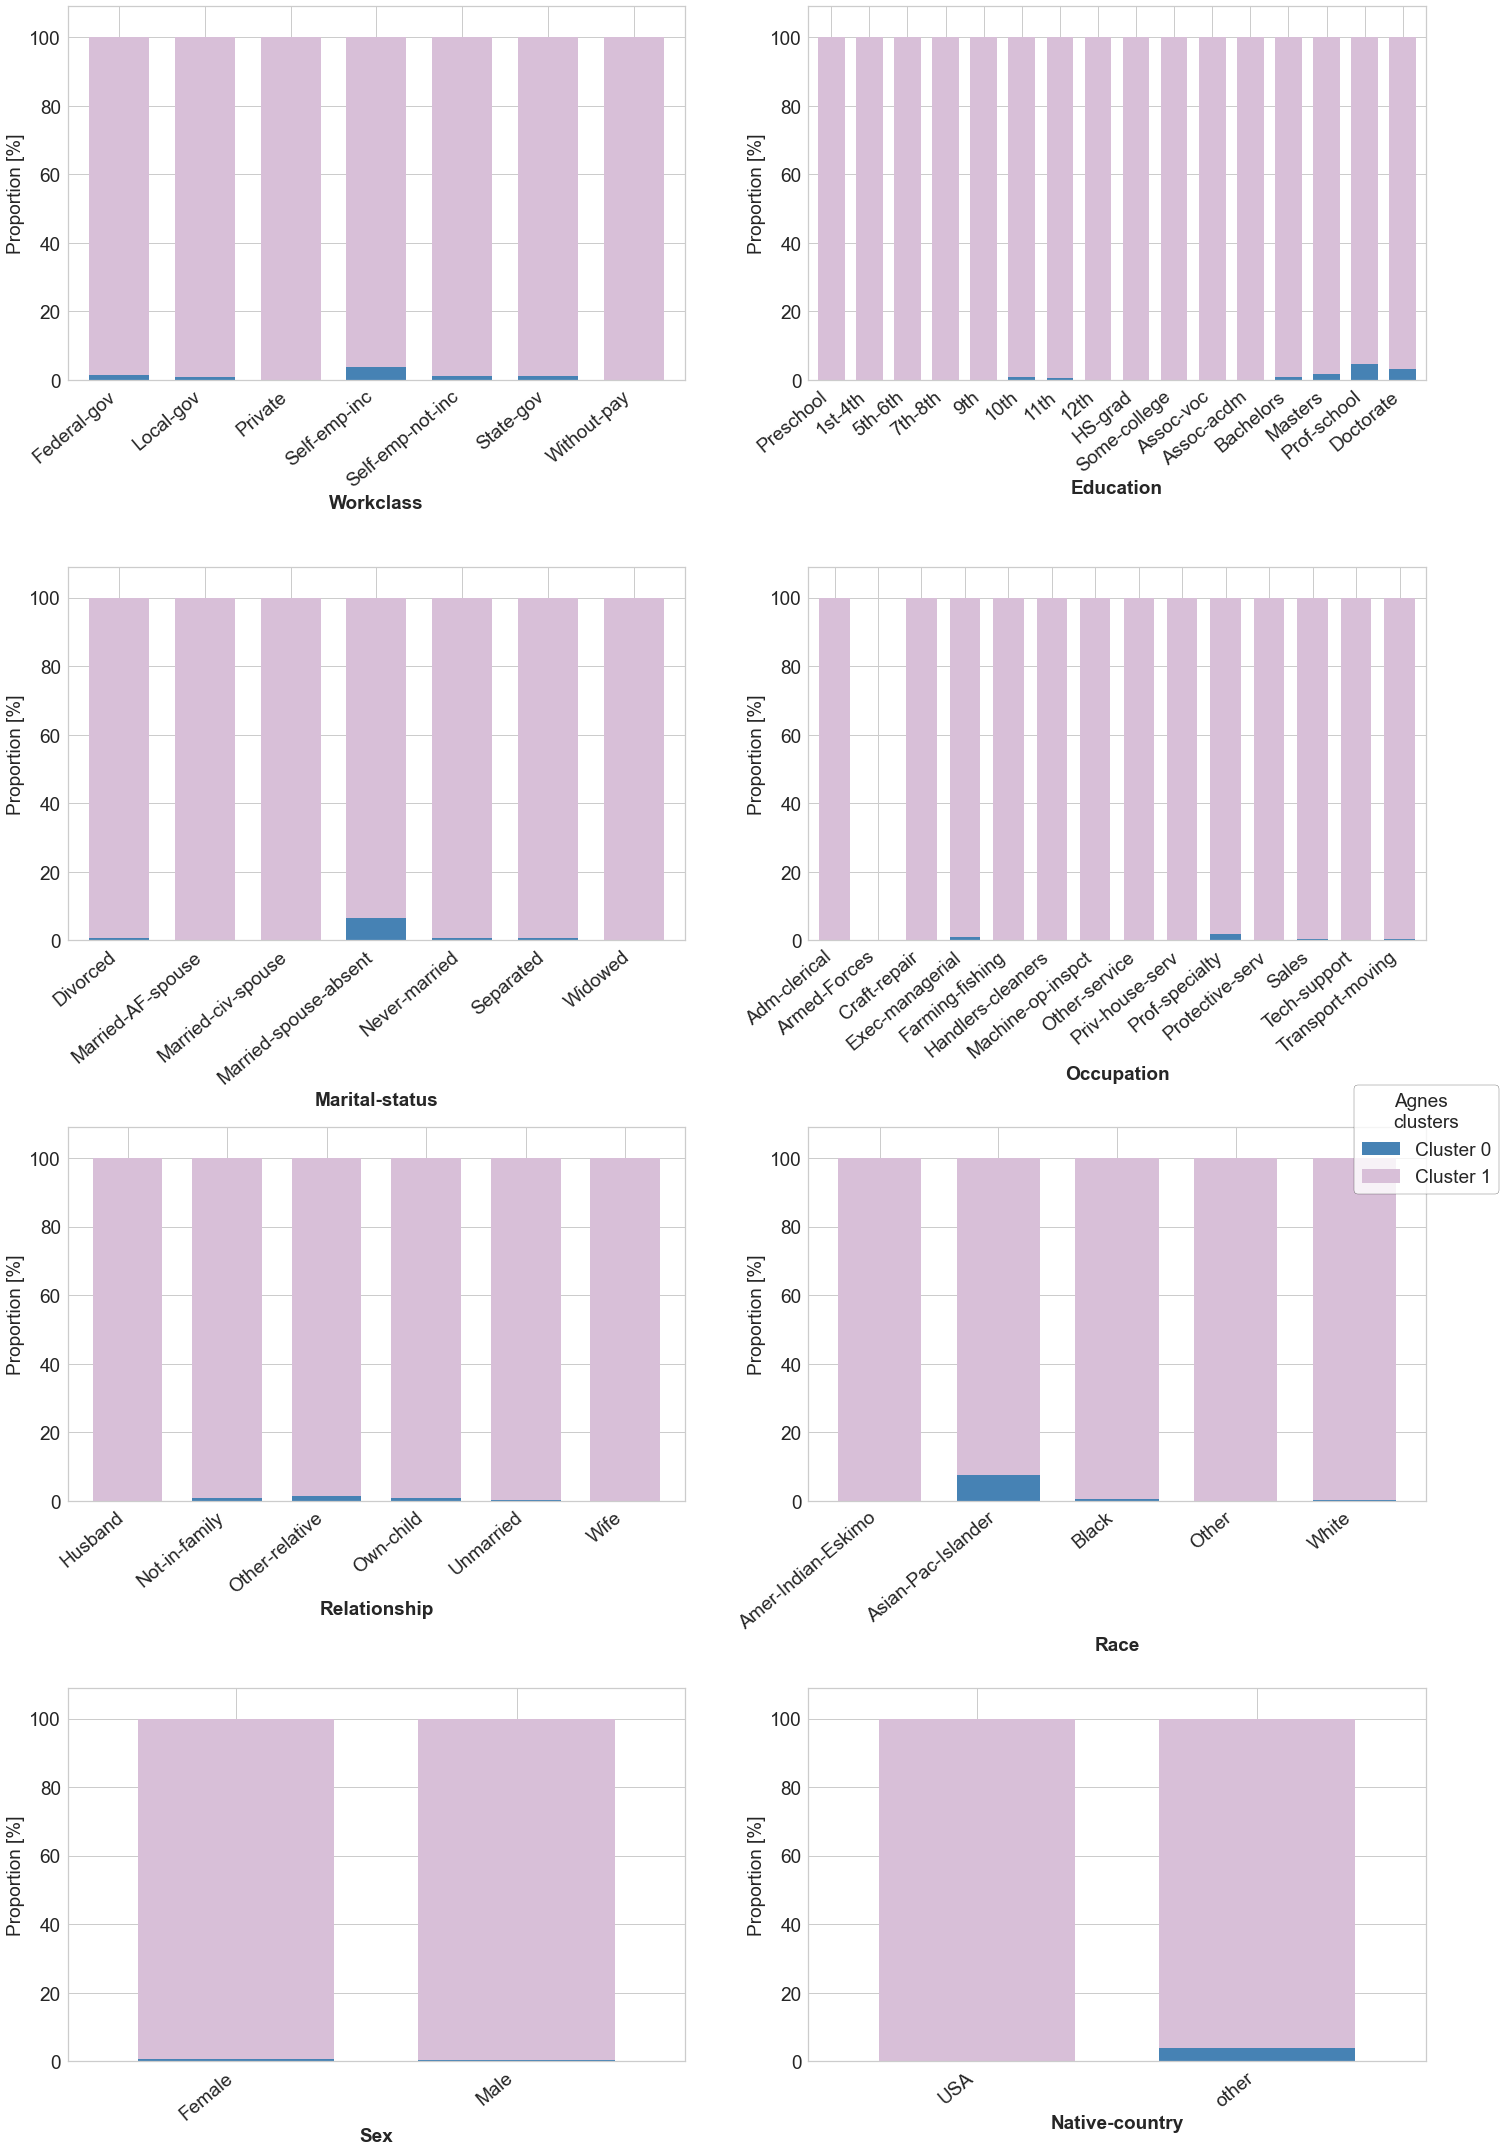

In [84]:
education_sorted = [
    'Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th',
    'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters',
    'Prof-school', 'Doctorate'
]

colors = ['steelblue', 'thistle']
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 30))

for i, feature in enumerate(categorical_columns):
    ax = axes[i // 2, i % 2]
    
    if feature == 'education':
        grouped = X_with_labels.groupby([pd.Categorical(X_with_labels['education'], categories=education_sorted, ordered=True), 'cluster_agnes']).size().unstack()
    else:
        grouped = X_with_labels.groupby([feature, 'cluster_agnes']).size().unstack()
        
    grouped_percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100
    grouped_percentages.plot(kind='bar', stacked=True, color=colors, width=0.7, fontsize=15, ax=ax)
    
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=19, rotation=40, ha='right')
    ax.set_yticks(ax.get_yticks())
    ax.set_xlabel(f"{feature.capitalize()}", fontsize=19, weight='bold')
    ax.set_ylabel("Proportion [%]", fontsize=19)
    # ax.legend(title='K-Prototypes clusters', loc='upper right', fontsize=19, title_fontsize=19, fancybox=True)
    # legend = ax.legend(title='Cluster', loc='upper right', fontsize=19, title_fontsize=19)
    # legend.get_frame().set_edgecolor('black')
#     legend.get_frame().set_linewidth(1)
    ax.legend().remove()
    ax.set_ylim(0, 109)
    ax.tick_params(axis='y', labelsize=19)
# plt.legend(title='K-Prototypes clusters', loc='upper right',fontsize=19)
fig.legend(title='Agnes\nclusters', labels=['Cluster 0', 'Cluster 1'], loc='upper right', fontsize=19, title_fontsize=19, bbox_to_anchor=(1.05, 0.5), edgecolor='black', frameon=True)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.savefig('clustering_plots/agnes_variables_categorical.pdf')
plt.show()

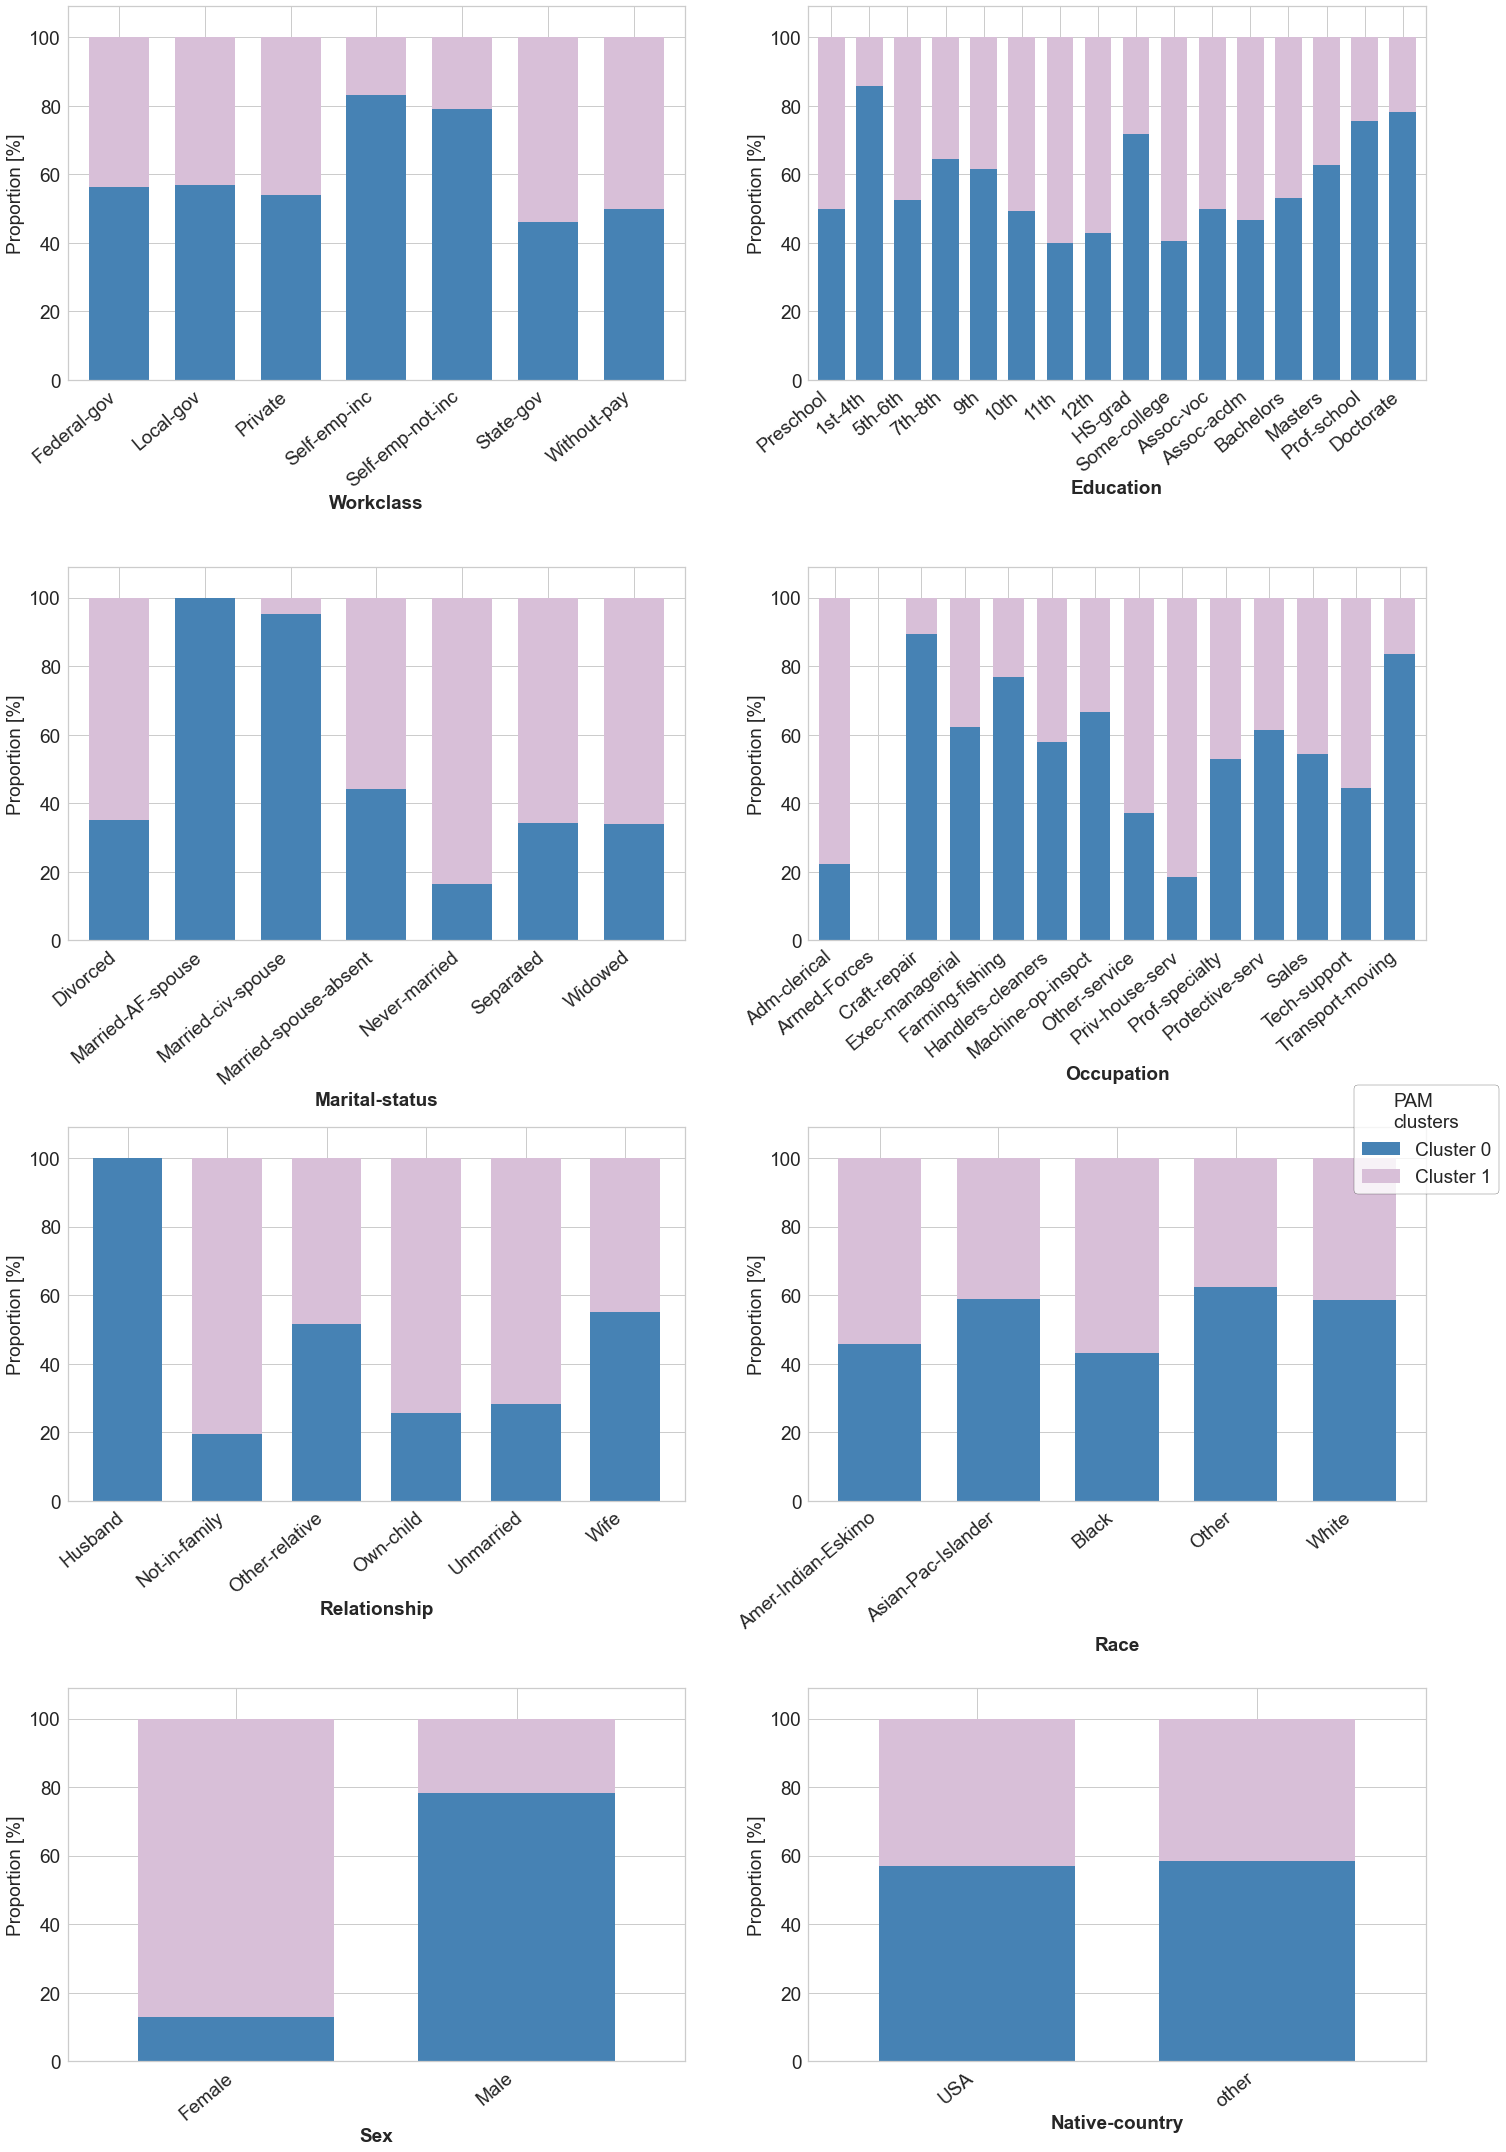

In [86]:
education_sorted = [
    'Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th',
    'HS-grad', 'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters',
    'Prof-school', 'Doctorate'
]

colors = ['steelblue', 'thistle']
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 30))

for i, feature in enumerate(categorical_columns):
    ax = axes[i // 2, i % 2]
    
    if feature == 'education':
        grouped = X_with_labels.groupby([pd.Categorical(X_with_labels['education'], categories=education_sorted, ordered=True), 'cluster_pam']).size().unstack()
    else:
        grouped = X_with_labels.groupby([feature, 'cluster_pam']).size().unstack()
        
    grouped_percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100
    grouped_percentages.plot(kind='bar', stacked=True, color=colors, width=0.7, fontsize=15, ax=ax)
    
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=19, rotation=40, ha='right')
    ax.set_yticks(ax.get_yticks())
    ax.set_xlabel(f"{feature.capitalize()}", fontsize=19, weight='bold')
    ax.set_ylabel("Proportion [%]", fontsize=19)
    # ax.legend(title='K-Prototypes clusters', loc='upper right', fontsize=19, title_fontsize=19, fancybox=True)
    # legend = ax.legend(title='Cluster', loc='upper right', fontsize=19, title_fontsize=19)
    # legend.get_frame().set_edgecolor('black')
#     legend.get_frame().set_linewidth(1)
    ax.legend().remove()
    ax.set_ylim(0, 109)
    ax.tick_params(axis='y', labelsize=19)
# plt.legend(title='K-Prototypes clusters', loc='upper right',fontsize=19)
fig.legend(title='PAM\nclusters', labels=['Cluster 0', 'Cluster 1'], loc='upper right', fontsize=19, title_fontsize=19, bbox_to_anchor=(1.05, 0.5), edgecolor='black', frameon=True)

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.savefig('clustering_plots/PAM_variables_categorical.pdf')
plt.show()